In [1]:
# Import standard libraries
import os

# Import data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning models and utilities
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Import Jupyter display utilities
from IPython.display import display, HTML

In [2]:
# Create directory for saving visualizations
os.makedirs('images', exist_ok=True)

# Set to True to save all plots to images/ directory
SAVE_PLOTS = True

In [ ]:
# Set data directory path
DATA_PATH = "/your/data/path"

# Load all datasets
script_lines = pd.read_csv(f"{DATA_PATH}/simpsons_script_lines.csv", low_memory=False)
locations = pd.read_csv(f"{DATA_PATH}/simpsons_locations.csv")
characters = pd.read_csv(f"{DATA_PATH}/simpsons_characters.csv")
episodes = pd.read_csv(f"{DATA_PATH}/simpsons_episodes.csv")

In [4]:
# Calculate median IMDB rating to split episodes into popular/unpopular
median_rating = episodes['imdb_rating'].median()
print(f"Median rating: {median_rating}")

# Create binary popularity labels (1 = Popular, 0 = Unpopular)
episodes.loc[episodes['imdb_rating'] >= median_rating, 'good_bad'] = 1
episodes.loc[episodes['imdb_rating'] < median_rating, 'good_bad'] = 0

Median rating: 7.3


In [5]:
# Create base dataset with core episode information
model_data = episodes[["id", "title", "original_air_year", "season", "us_viewers_in_millions"]].copy()
model_data.columns = ["episode_id", "episode_title", "year_aired", "episode_season", "episode_views (millions)"]

# Normalize episode titles (lowercase, remove punctuation, clean whitespace)
model_data['episode_title'] = (
    model_data['episode_title']
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

# Map binary labels to categorical popularity labels
model_data["episode_popularity"] = episodes['good_bad'].map({1: "Popular", 0: "Unpopular"})

print(f"Total episodes: {len(model_data)}")
model_data.head()

Total episodes: 600


,episode_id,episode_title,year_aired,episode_season,episode_views (millions),episode_popularity
0,10,homers night out,1990,1,30.3,Popular
1,12,krusty gets busted,1990,1,30.4,Popular
2,14,bart gets an f,1990,2,33.6,Popular
3,17,two cars in every garage and three eyes on eve...,1990,2,26.1,Popular
4,19,dead putting society,1990,2,25.4,Popular


In [6]:
# Filter to only speaking lines
speaking_lines = script_lines[script_lines['speaking_line'].str.lower() == "true"]

# Count unique speaking characters per episode
char_counts = (
    speaking_lines
    .groupby('episode_id')['character_id']
    .nunique()
    .reset_index()
    .rename(columns={'character_id': 'num_characters'})
)
model_data = model_data.merge(char_counts, on='episode_id', how='left')

# Calculate total lines per character across all episodes
char_totals = (
    speaking_lines
    .groupby('character_id')
    .size()
    .reset_index(name='total_lines')
)

# Convert character IDs to integers and aggregate duplicates
char_totals['character_id'] = pd.to_numeric(char_totals['character_id'], errors='coerce').astype('Int64')
char_totals = (
    char_totals
    .groupby('character_id')['total_lines']
    .sum()
    .reset_index()
    .sort_values('total_lines', ascending=False)
)

# Add character names
char_totals = char_totals.merge(
    characters[['id', 'name']], 
    left_on='character_id', 
    right_on='id', 
    how='left'
).drop(columns=['id'])

print("Top 10 Characters by Line Count:")
print(char_totals.head(10))
print(f"\nTop 4: {char_totals.head(4)['name'].tolist()}")

# Count lines from top 4 main characters per episode (Homer, Marge, Bart, Lisa)
top_chars = [2, 1, 8, 9]
popular_lines = (
    speaking_lines[
        pd.to_numeric(speaking_lines['character_id'], errors='coerce').isin(top_chars)
    ]
    .groupby('episode_id')
    .size()
    .reset_index(name='popular_character_lines')
)

# Merge popular character lines and fill missing values
model_data = model_data.merge(popular_lines, on='episode_id', how='left')
model_data['num_characters'] = model_data['num_characters'].fillna(0)
model_data['popular_character_lines'] = model_data['popular_character_lines'].fillna(0).astype('Int64')

print(f"\nEpisodes with character data: {model_data['num_characters'].notna().sum()}")
print(f"Episodes with popular character lines: {(model_data['popular_character_lines'] > 0).sum()}")

Top 10 Characters by Line Count:
   character_id  total_lines                 name
0             2        28166        Homer Simpson
1             1        13289        Marge Simpson
2             8        13200         Bart Simpson
3             9        10893         Lisa Simpson
4            15         3121  C. Montgomery Burns
5            17         2809          Moe Szyslak
6             3         2390      Seymour Skinner
7            11         2057         Ned Flanders
8            31         1875       Grampa Simpson
9            25         1798  Milhouse Van Houten

Top 4: ['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']

Episodes with character data: 600
Episodes with popular character lines: 564


In [7]:
# Identify the most frequently occurring location for each episode
primary_locs = (
    script_lines
    .groupby(['episode_id', 'location_id'])
    .size()
    .reset_index(name='count')
    .sort_values(['episode_id', 'count'], ascending=[True, False])
    .drop_duplicates(subset=['episode_id'], keep='first')
    [['episode_id', 'location_id']]
)

# Merge primary location IDs
model_data = model_data.merge(primary_locs, on='episode_id', how='left')

# Add location names
model_data = model_data.merge(
    locations[['id', 'normalized_name']], 
    left_on='location_id', 
    right_on='id', 
    how='left'
)

# Clean up and rename location columns
model_data = model_data.drop(columns=['id']).rename(columns={
    'location_id': 'primary_location_id',
    'normalized_name': 'primary_location'
})
model_data['primary_location_id'] = model_data['primary_location_id'].astype('Int64')

print(f"Episodes with location data: {model_data['primary_location_id'].notna().sum()}")

Episodes with location data: 564


In [8]:
# Reorder columns to final structure
model_data = model_data[[
    'episode_id', 'episode_title', 'episode_season', 'episode_views (millions)',
    'year_aired', 'primary_location_id', 'primary_location',
    'num_characters', 'popular_character_lines', 'episode_popularity'
]]

# Display final dataset summary
print("=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"Total episodes: {len(model_data)}")
print(f"\nPopularity distribution:")
print(model_data['episode_popularity'].value_counts())
print(f"\nMissing data per column:")
print(model_data.isna().sum())
print("=" * 60)

model_data.head()

FINAL DATASET SUMMARY
Total episodes: 600

Popularity distribution:
episode_popularity
Popular      300
Unpopular    297
Name: count, dtype: int64

Missing data per column:
episode_id                   0
episode_title                0
episode_season               0
episode_views (millions)     6
year_aired                   0
primary_location_id         36
primary_location            36
num_characters               0
popular_character_lines      0
episode_popularity           3
dtype: int64


,episode_id,episode_title,episode_season,episode_views (millions),year_aired,primary_location_id,primary_location,num_characters,popular_character_lines,episode_popularity
0,10,homers night out,1,30.3,1990,5,simpson home,40.0,152,Popular
1,12,krusty gets busted,1,30.4,1990,25,simpson living room,33.0,106,Popular
2,14,bart gets an f,2,33.6,1990,27,classroom,27.0,142,Popular
3,17,two cars in every garage and three eyes on eve...,2,26.1,1990,5,simpson home,28.0,86,Popular
4,19,dead putting society,2,25.4,1990,247,miniature golf course,14.0,192,Popular


In [9]:
# Check how many episodes have complete data (no missing values)
complete_data = model_data.dropna()
print(f"Episodes with complete data: {len(complete_data)}")

# Analyze ALL missing data patterns
print("\nMissing data breakdown:")
print(f"Missing viewership only: {((model_data['episode_views (millions)'].isna()) & (model_data['num_characters'].notna()) & (model_data['primary_location'].notna()) & (model_data['episode_popularity'].notna())).sum()}")
print(f"Missing location only: {((model_data['primary_location'].isna()) & (model_data['episode_views (millions)'].notna()) & (model_data['num_characters'].notna()) & (model_data['episode_popularity'].notna())).sum()}")
print(f"Missing popularity only: {((model_data['episode_popularity'].isna()) & (model_data['num_characters'].notna()) & (model_data['primary_location'].notna()) & (model_data['episode_views (millions)'].notna())).sum()}")
print(f"Missing viewership AND location: {((model_data['episode_views (millions)'].isna()) & (model_data['primary_location'].isna()) & (model_data['num_characters'].notna()) & (model_data['episode_popularity'].notna())).sum()}")
print(f"Missing viewership AND popularity: {((model_data['episode_views (millions)'].isna()) & (model_data['episode_popularity'].isna()) & (model_data['num_characters'].notna()) & (model_data['primary_location'].notna())).sum()}")
print(f"Missing location AND popularity: {((model_data['primary_location'].isna()) & (model_data['episode_popularity'].isna()) & (model_data['num_characters'].notna()) & (model_data['episode_views (millions)'].notna())).sum()}")
print(f"Missing viewership, location, AND popularity: {((model_data['episode_views (millions)'].isna()) & (model_data['primary_location'].isna()) & (model_data['episode_popularity'].isna())).sum()}")

print(f"\nTotal episodes with ANY missing data: {model_data.isna().any(axis=1).sum()}")

Episodes with complete data: 561

Missing data breakdown:
Missing viewership only: 3
Missing location only: 33
Missing popularity only: 0
Missing viewership AND location: 0
Missing viewership AND popularity: 0
Missing location AND popularity: 0
Missing viewership, location, AND popularity: 3

Total episodes with ANY missing data: 39


In [ ]:
# Remove rows with missing values and convert popularity to binary
model_data = model_data.dropna().copy()
model_data['episode_popularity'] = model_data['episode_popularity'].map({'Unpopular': 0, 'Popular': 1})

print(f"Final modeling dataset: {len(model_data)} episodes")
model_data.head()

# Save cleaned dataset for modeling
OUTPUT_PATH = "/your/data/path/simpsons_modeling_data.csv"
model_data.to_csv(OUTPUT_PATH, index=False)

Final modeling dataset: 561 episodes


In [11]:
# Display dataset structure and data types
print("Dataset shape:", model_data.shape)
print("\nColumn types:\n", model_data.dtypes)

# Generate descriptive statistics for numeric features
numeric_vars = ['episode_season', 'year_aired', 'episode_views (millions)',
                'num_characters', 'popular_character_lines']
model_data[numeric_vars].describe().round(2)

Dataset shape: (561, 10)

Column types:
 episode_id                    int64
episode_title                object
episode_season                int64
episode_views (millions)    float64
year_aired                    int64
primary_location_id           Int64
primary_location             object
num_characters              float64
popular_character_lines       Int64
episode_popularity            int64
dtype: object


,episode_season,year_aired,episode_views (millions),num_characters,popular_character_lines
count,561.00,561.00,561.00,561.00,561.0
mean,13.35,2001.96,12.29,35.75,116.29
std,7.33,7.35,6.30,8.61,35.05
min,1.00,1989.00,2.67,11.00,26.0
25%,7.00,1996.00,7.60,29.00,92.0
50%,13.00,2002.00,10.60,35.00,117.0
75%,20.00,2008.00,15.50,41.00,136.0
max,26.00,2015.00,33.60,64.00,225.0


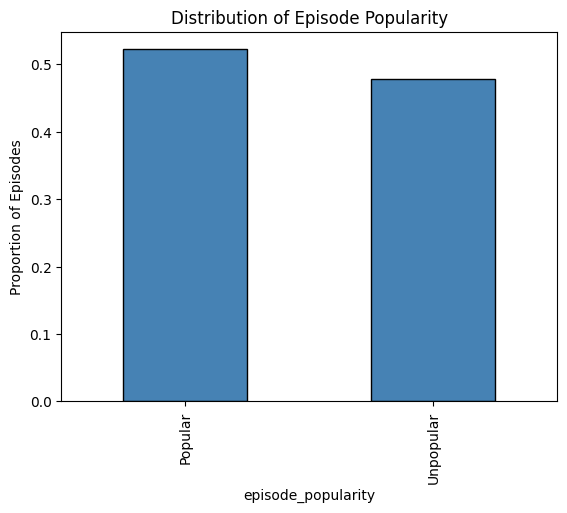

In [12]:
# Visualize the distribution of popular vs unpopular episodes
pop_counts = model_data['episode_popularity'].value_counts(normalize=True).rename({1:'Popular', 0:'Unpopular'})
pop_counts.plot(kind='bar', color=['steelblue', 'steelblue'], edgecolor='black')
plt.title("Distribution of Episode Popularity")
plt.ylabel("Proportion of Episodes")
if SAVE_PLOTS:
    plt.savefig('images/popularity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

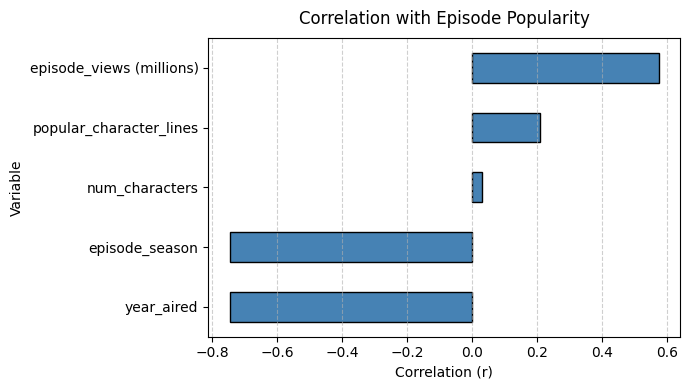

episode_season             -0.745
year_aired                 -0.746
episode_views (millions)    0.575
num_characters              0.032
popular_character_lines     0.208
Name: episode_popularity, dtype: float64


In [13]:
# Calculate correlations between numeric features and episode popularity
corrs = model_data[numeric_vars + ['episode_popularity']].corr()['episode_popularity'].drop('episode_popularity')

# Visualize correlations with horizontal bar chart
plt.figure(figsize=(7,4))
corrs.sort_values().plot(kind='barh', color='steelblue', edgecolor='black')
plt.title("Correlation with Episode Popularity", pad=10)
plt.xlabel("Correlation (r)")
plt.ylabel("Variable")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig('images/correlation_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(corrs.round(3))

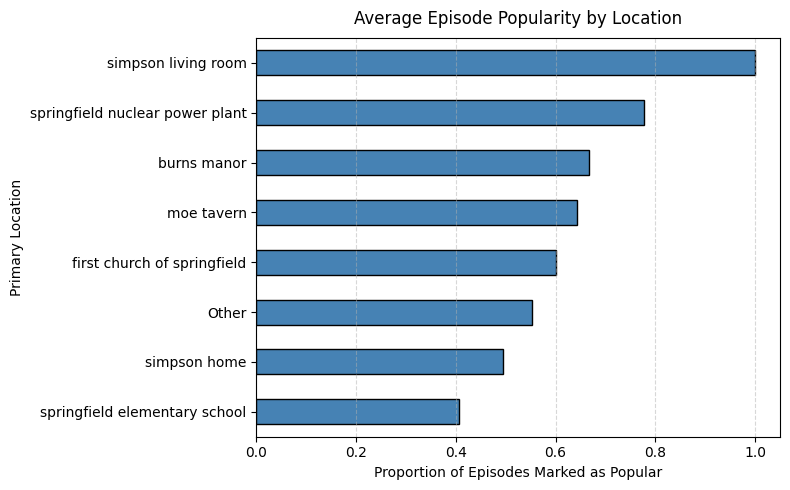

primary_location_grouped
simpson living room                1.00
springfield nuclear power plant    0.78
burns manor                        0.67
moe tavern                         0.64
first church of springfield        0.60
Other                              0.55
simpson home                       0.49
springfield elementary school      0.41
Name: episode_popularity, dtype: float64


In [14]:
# Group rare locations (fewer than 5 episodes) into "Other" category
loc_counts = model_data['primary_location'].value_counts()
rare_locs = loc_counts[loc_counts < 5].index
model_data['primary_location_grouped'] = model_data['primary_location'].replace(rare_locs, 'Other')

# Calculate average popularity (proportion of popular episodes) per location
loc_popularity = (
    model_data
    .groupby("primary_location_grouped")["episode_popularity"]
    .mean()
    .sort_values(ascending=False)
)

# Visualize average popularity by location with horizontal bar chart
plt.figure(figsize=(8,5))
loc_popularity.plot(kind="barh", color="steelblue", edgecolor="black")
plt.title("Average Episode Popularity by Location", pad=10)
plt.xlabel("Proportion of Episodes Marked as Popular")
plt.ylabel("Primary Location")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig('images/location_popularity.png', dpi=300, bbox_inches='tight')
plt.show()

print(loc_popularity.round(2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

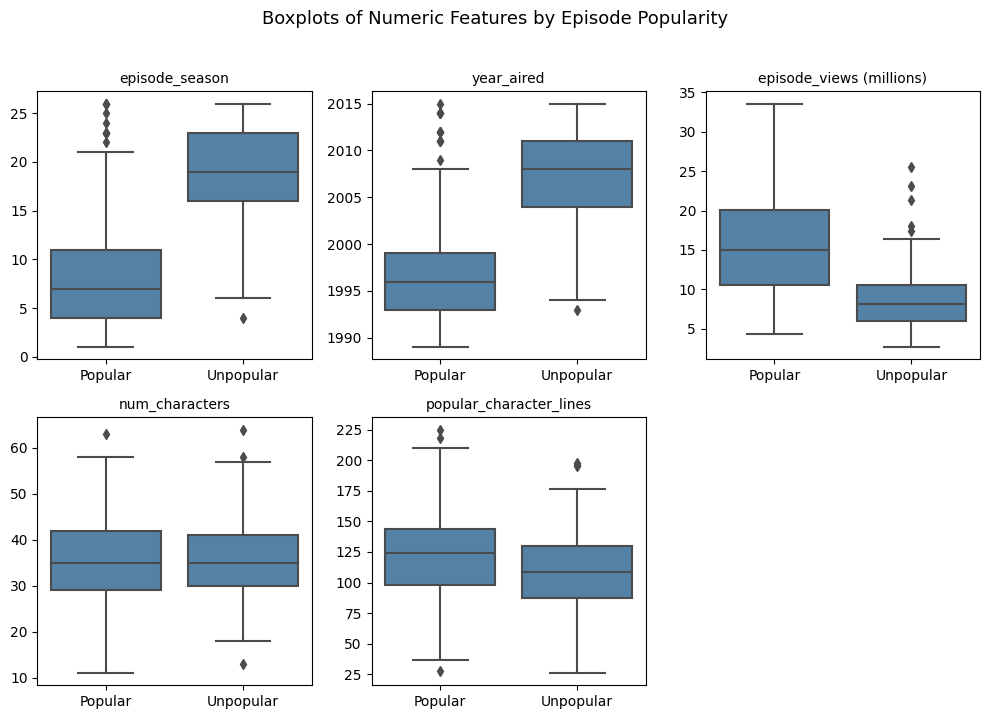

In [15]:
# Create visualization dataset with categorical popularity labels
viz_data = model_data.copy()
viz_data['episode_popularity'] = viz_data['episode_popularity'].map({1: 'Popular', 0: 'Unpopular'})

# Create boxplots comparing numeric features between popular and unpopular episodes
fig, axes = plt.subplots(2, 3, figsize=(10,7))
axes = axes.flatten()

for i, col in enumerate(numeric_vars):
    sns.boxplot(
        x='episode_popularity',
        y=col,
        data=viz_data,
        ax=axes[i],
        color='steelblue'
    )
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove unused subplot panels
for j in range(len(numeric_vars), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots of Numeric Features by Episode Popularity", fontsize=13, y=1.02)
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig('images/feature_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Define classification models to compare
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Neural Net": MLPClassifier(hidden_layer_sizes=(32,16), max_iter=500, random_state=42)
}

# Define incremental feature sets to test
feature_sets = {
    "Metadata": ['episode_season', 'year_aired'],
    "Metadata + Viewership": ['episode_season', 'year_aired', 'episode_views (millions)'],
    "Metadata + Viewership + Character Dynamics": [
        'episode_season', 'year_aired', 'episode_views (millions)',
        'num_characters', 'popular_character_lines'
    ],
    "Metadata + Viewership + Character Dynamics + Episode Location": [
        'episode_season', 'year_aired', 'episode_views (millions)',
        'num_characters', 'popular_character_lines'
    ] + [col for col in model_data.columns if col.startswith('loc_')]
}

# Define hyperparameter grids for grid search
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Neural Net": {
        "hidden_layer_sizes": [(32,), (32,16), (64,32)],
        "alpha": [0.0001, 0.001],
        "learning_rate_init": [0.001, 0.01]
    }
}

In [16]:
# Train and evaluate models with grid search across all feature sets
results = []
scaler = StandardScaler()

for group_name, columns in feature_sets.items():
    # Prepare features and target
    X = model_data[columns]
    y = model_data['episode_popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features for models that benefit from scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, base_model in base_models.items():
        # Use scaled data for Logistic Regression and Neural Net, raw data for Random Forest
        X_train_used = X_train_scaled if model_name != "Random Forest" else X_train
        X_test_used = X_test_scaled if model_name != "Random Forest" else X_test
        
        # Perform grid search to find best hyperparameters
        grid = GridSearchCV(base_model, param_grids[model_name], cv=3, scoring='f1', n_jobs=4)
        grid.fit(X_train_used, y_train)
        
        # Evaluate best model on test set
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test_used)
        
        # Store results
        results.append({
            "Model": model_name,
            "Feature Group": group_name,
            "Best Params": grid.best_params_,
            "Precision": precision_score(y_test, preds),
            "Recall": recall_score(y_test, preds),
            "F1": f1_score(y_test, preds)
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

/Users/eshan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eshan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eshan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eshan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eshan/anaconda3/lib/python3.1

In [17]:
# Order results by model and feature set for clean presentation
model_order = ["Logistic Regression", "Random Forest", "Neural Net"]
feature_order = [
    "Metadata",
    "Metadata + Viewership",
    "Metadata + Viewership + Character Dynamics",
    "Metadata + Viewership + Character Dynamics + Episode Location"
]

# Apply categorical ordering
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df["Feature Group"] = pd.Categorical(results_df["Feature Group"], categories=feature_order, ordered=True)

# Sort and clean up results table
results_df = results_df.sort_values(by=["Model", "Feature Group"]).reset_index(drop=True)
results_df = results_df.drop(columns=["Best Params"], errors="ignore")

# Display all row labels without repetition suppression
pd.set_option('display.multi_sparse', False)

# Print formatted results table
print("\n=== Model Comparison Results ===\n")
print(results_df.to_string(index=False, justify="center", col_space=12, formatters={
    "Precision": "{:.3f}".format,
    "Recall": "{:.3f}".format,
    "F1": "{:.3f}".format 
}))


=== Model Comparison Results ===

       Model                                Feature Group                          Precision      Recall         F1     
Logistic Regression                                                      Metadata    0.864        0.785        0.823    
Logistic Regression                                         Metadata + Viewership    0.864        0.785        0.823    
Logistic Regression                    Metadata + Viewership + Character Dynamics    0.873        0.846        0.859    
Logistic Regression Metadata + Viewership + Character Dynamics + Episode Location    0.873        0.846        0.859    
      Random Forest                                                      Metadata    0.926        0.769        0.840    
      Random Forest                                         Metadata + Viewership    0.925        0.754        0.831    
      Random Forest                    Metadata + Viewership + Character Dynamics    0.923        0.738        0.821  

In [18]:
# Create styled HTML table with best scores highlighted
highlight = pd.DataFrame('', index=results_df.index, columns=results_df.columns)

# Bold the maximum value in each metric column
for col in ['Precision', 'Recall', 'F1']:
    max_val = results_df[col].max()
    highlight.loc[results_df[col] == max_val, col] = 'font-weight: bold;'

# Apply styling to results table
styled = (
    results_df.style
    .set_caption("Model Comparison: Precision, Recall, and F1 Scores")
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('font-size', '12pt')]}
    ])
    .format({'Precision': '{:.3f}', 'Recall': '{:.3f}', 'F1': '{:.3f}'})
    .hide(axis='index')
    .set_properties(**{'text-align': 'center', 'border': '1px solid black', 'font-size': '9pt'})
    .apply(lambda _: highlight, axis=None)
)

# Display styled table
display(HTML(styled.to_html()))

Model,Feature Group,Precision,Recall,F1
Logistic Regression,Metadata,0.864,0.785,0.823
Logistic Regression,Metadata + Viewership,0.864,0.785,0.823
Logistic Regression,Metadata + Viewership + Character Dynamics,0.873,0.846,0.859
Logistic Regression,Metadata + Viewership + Character Dynamics + Episode Location,0.873,0.846,0.859
Random Forest,Metadata,0.926,0.769,0.840
Random Forest,Metadata + Viewership,0.925,0.754,0.831
Random Forest,Metadata + Viewership + Character Dynamics,0.923,0.738,0.821
Random Forest,Metadata + Viewership + Character Dynamics + Episode Location,0.923,0.738,0.821
Neural Net,Metadata,0.926,0.769,0.840
Neural Net,Metadata + Viewership,0.925,0.754,0.831
